In [1]:
# 安裝必要的庫
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install monai[all] nibabel matplotlib tqdm
!pip install git
!pip install ipywidgets
!git clone https://github.com/kairaun/Sam.git
!git clone https://github.com/kairaun/CardiacSegV2.git

Looking in indexes: https://download.pytorch.org/whl/cu118


ERROR: Could not find a version that satisfies the requirement git (from versions: none)
ERROR: No matching distribution found for git


fatal: destination path 'Sam' already exists and is not an empty directory.
fatal: destination path 'CardiacSegV2' already exists and is not an empty directory.


In [1]:
import os
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# MONAI 是專門處理 NIfTI (.nii) 的強大工具
from monai.utils import set_determinism
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    Orientationd, ScaleIntensityRanged, CropForegroundd,
    RandCropByPosNegLabeld, EnsureTyped, AsDiscreted
)
from monai.networks.nets import UNet, SwinUNETR # 如果不用你的 CardiacSegV2，可以用這些強大模型
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, decollate_batch

# 設定亂數種子以確保結果可重現
set_determinism(seed=0)

# 1. 設定你的資料路徑 (請依照你的實際路徑修改)
data_dir = "C:/Users/user/AICUP/dataset"  # 假設資料放在這裡
train_images = sorted(glob.glob(os.path.join(data_dir, "Train", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "Train_Labels", "*.nii.gz")))
test_images = sorted(glob.glob(os.path.join(data_dir, "Test", "*.nii.gz")))

# 建立字典列表
data_dicts = [{"image": image_name, "label": label_name}
              for image_name, label_name in zip(train_images, train_labels)]

# 切分訓練集與驗證集 (40個訓練, 10個驗證)
train_files, val_files = data_dicts[:40], data_dicts[40:]
print(f"Training count: {len(train_files)}, Validation count: {len(val_files)}")

Training count: 40, Validation count: 10


In [2]:
# === 步驟 2：資料前處理 (進階資料增強版) ===
import os
import glob
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    Orientationd, ScaleIntensityRanged, CropForegroundd,
    RandCropByPosNegLabeld, EnsureTyped, SpatialPadd,
    RandFlipd, RandRotate90d, RandShiftIntensityd, RandGaussianNoised
)
from monai.data import CacheDataset, DataLoader

# 1. 設定資料路徑
train_images = sorted(glob.glob(os.path.join(data_dir, "Train", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "Train_Labels", "*.nii.gz")))
test_images = sorted(glob.glob(os.path.join(data_dir, "Test", "*.nii.gz")))

data_dicts = [{"image": image_name, "label": label_name}
              for image_name, label_name in zip(train_images, train_labels)]

# 切分訓練集與驗證集
train_files, val_files = data_dicts[:40], data_dicts[40:]

# 2. 設定參數
roi_size = (96, 96, 96) 
batch_size = 1 

# 3. 定義轉換 (加入大量增強)
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ScaleIntensityRanged(
        keys=["image"], a_min=-175, a_max=250,
        b_min=0.0, b_max=1.0, clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    
    SpatialPadd(keys=["image", "label"], spatial_size=roi_size),

    # --- 進階資料增強開始 ---
    # 1. 隨機裁切 (維持不變)
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=roi_size,
        pos=1, neg=1, num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    
    # 2. 隨機翻轉 (上下、左右、前後)
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    
    # 3. 隨機旋轉 90 度
    RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),
    
    # 4. 隨機亮度偏移 (模擬不同機器的 CT 差異)
    # 這一項只對 image 做，label 不能動
    RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
    
    # 5. 隨機高斯雜訊 (模擬成像雜訊)
    RandGaussianNoised(keys=["image"], prob=0.1, mean=0.0, std=0.1),
    # --- 進階資料增強結束 ---

    EnsureTyped(keys=["image", "label"]),
])

# 驗證集不做增強，維持原樣
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ScaleIntensityRanged(
        keys=["image"], a_min=-175, a_max=250,
        b_min=0.0, b_max=1.0, clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])

print("[INFO] 正在初始化 Dataset (增強版)...")
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

print("[INFO] Dataset 初始化完成！")

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


[INFO] 正在初始化 Dataset (增強版)...


Loading dataset: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

[INFO] Dataset 初始化完成！


image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


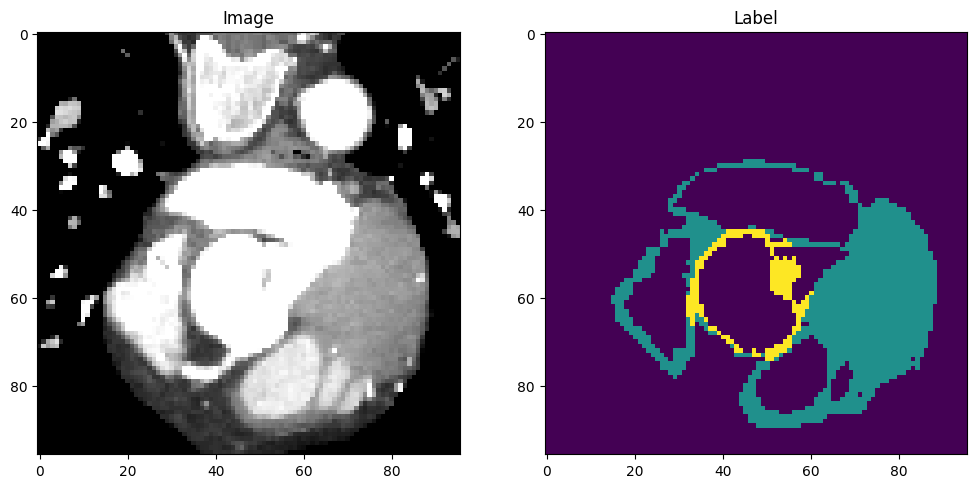

In [3]:
# 補上漏掉的 import
from monai.utils import first

# 檢查一筆資料
check_data = first(train_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image[:, :, 50], cmap="gray") # 顯示第 50 層切片 (你可以改數字換層)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label[:, :, 50])
plt.show()

In [4]:
# === 步驟 4：定義模型、載入預訓練權重 (修正載入 0 層問題版) ===
from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU
import torch
import torch.nn as nn
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 定義模型
model = SwinUNETR(
    in_channels=1,
    out_channels=4, 
    feature_size=48,
    use_checkpoint=True,
).to(device)

# --- 載入預訓練權重 ---
pretrained_path = "./swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt"

if os.path.exists(pretrained_path):
    print(f"[INFO] 發現預訓練權重: {pretrained_path}")
    print("[INFO] 正在載入並遷移權重...")
    
    # 讀取檔案
    checkpoint = torch.load(pretrained_path, map_location=device, weights_only=False)
    
    # [關鍵修正] 檢查是否包在 state_dict 裡
    if "state_dict" in checkpoint:
        print("[INFO] 偵測到權重包含在 'state_dict' 中，正在提取...")
        pretrained_dict = checkpoint["state_dict"]
    else:
        pretrained_dict = checkpoint

    # 取得目前模型結構
    model_dict = model.state_dict()
    
    # 過濾鍵值
    filtered_dict = {k: v for k, v in pretrained_dict.items() 
                     if k in model_dict and v.shape == model_dict[k].shape}
    
    if len(filtered_dict) == 0:
        print("[ERROR] 依然載入 0 層！請檢查權重檔來源或模型設定。")
        # 嘗試印出前幾個 key 來除錯
        print("預訓練檔的前 5 個 Keys:", list(pretrained_dict.keys())[:5])
        print("目前模型的前 5 個 Keys:", list(model_dict.keys())[:5])
    else:
        # 更新模型
        model_dict.update(filtered_dict)
        model.load_state_dict(model_dict)
        print(f"[INFO] 成功載入預訓練權重！(共載入 {len(filtered_dict)}/{len(model_dict)} 層)")
        print("[INFO] 最後輸出層將使用隨機初始化以適應新的分類任務。")

else:
    print(f"[WARN] 找不到檔案 {pretrained_path}，將使用隨機初始化訓練。")
# --------------------

# 2. 定義類別權重
class_weights = torch.tensor([1.0, 1.0, 2.0, 10.0]).to(device)

# 3. 自定義 Loss
class CustomWeightedDiceCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.dice = DiceLoss(to_onehot_y=True, softmax=True)
        self.ce = nn.CrossEntropyLoss(weight=weights)
        
    def forward(self, pred, label):
        loss_d = self.dice(pred, label)
        loss_c = self.ce(pred, label.long().squeeze(1))
        return loss_d + loss_c

loss_function = CustomWeightedDiceCELoss(class_weights)

# 4. 優化器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# 5. 排程器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-6)

# 6. 指標
dice_metric = DiceMetric(include_background=False, reduction="mean")
iou_metric = MeanIoU(include_background=False, reduction="mean")

print("[INFO] 模型準備就緒。")

[INFO] 發現預訓練權重: ./swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
[INFO] 正在載入並遷移權重...
[INFO] 偵測到權重包含在 'state_dict' 中，正在提取...
[INFO] 成功載入預訓練權重！(共載入 157/159 層)
[INFO] 最後輸出層將使用隨機初始化以適應新的分類任務。
[INFO] 模型準備就緒。


In [5]:
# === 步驟 5：訓練迴圈 (完整版：餘弦退火 + Dice/IoU 計分 + Early Stopping) ===
import torch
import datetime
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import AsDiscrete
from monai.metrics import DiceMetric, MeanIoU
from tqdm import tqdm

# --- 1. 設定 Log 檔案 ---
current_time = datetime.datetime.now().strftime("%d_%H_%M")
log_filename = f"{current_time}.txt"
print(f"[INFO] 訓練紀錄將儲存於: {log_filename}")

# --- 2. 設定訓練參數 ---
max_epochs = 500
val_interval = 2
best_score = -1  # 綜合分數 (Dice+IoU)/2
best_score_epoch = -1
epoch_loss_values = []

# --- Early Stopping 設定 ---
patience = 50 
no_improvement_count = 0 

# --- 梯度累積與混合精度 ---
gradient_accumulation_steps = 4 
scaler = torch.amp.GradScaler('cuda')

# --- 定義指標 ---
dice_metric = DiceMetric(include_background=False, reduction="mean")
iou_metric = MeanIoU(include_background=False, reduction="mean")

post_pred = AsDiscrete(argmax=True, to_onehot=4)
post_label = AsDiscrete(to_onehot=4)

for epoch in range(max_epochs):
    print(f"-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    
    model.train()
    epoch_loss = 0
    step = 0
    
    train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    optimizer.zero_grad() 
    
    for i, batch_data in enumerate(train_bar):
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss = loss / gradient_accumulation_steps
        
        scaler.scale(loss).backward()
        
        if (i + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        current_loss = loss.item() * gradient_accumulation_steps
        epoch_loss += current_loss
        
        # 顯示當前 Loss 與 Learning Rate
        current_lr = optimizer.param_groups[0]['lr']
        train_bar.set_postfix({"loss": f"{current_loss:.4f}", "lr": f"{current_lr:.6f}"})

    # --- 關鍵：更新學習率 (Cosine Annealing) ---
    scheduler.step()
    # ----------------------------------------

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    # 寫入 Log
    with open(log_filename, "a") as f:
        f.write(f"epoch {epoch + 1} average lose = {epoch_loss:.4f}\n")
    
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # === 驗證階段 ===
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}")
            
            for val_data in val_bar:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                
                with torch.amp.autocast('cuda'):
                    val_outputs = sliding_window_inference(val_inputs, roi_size, 4, model)
                
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                
                dice_metric(y_pred=val_outputs, y=val_labels)
                iou_metric(y_pred=val_outputs, y=val_labels)

            # 取得平均分數
            current_dice = dice_metric.aggregate().item()
            current_iou = iou_metric.aggregate().item()
            
            dice_metric.reset()
            iou_metric.reset()
            
            # 計算綜合分數
            current_score = (current_dice + current_iou) / 2
            
            if current_score > best_score:
                best_score = current_score
                best_score_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print(f"\n[新紀錄] 模型已儲存 | Score: {best_score:.4f} (Dice: {current_dice:.4f}, IoU: {current_iou:.4f})")
                
                with open(log_filename, "a") as f:
                    f.write(f" >> New Best Score: {best_score:.4f} (Dice: {current_dice:.4f}, IoU: {current_iou:.4f}) at epoch {epoch+1}\n")
                
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                print(f"\n[未進步] Score: {current_score:.4f} | 連續 {no_improvement_count}/{patience} 次未創新高")
            
            if no_improvement_count >= patience:
                print(f"\n[STOP] 觸發早停機制！連續 {patience} 次驗證未進步。")
                print(f"訓練結束。最佳模型 Score: {best_score:.4f} at Epoch {best_score_epoch}")
                with open(log_filename, "a") as f:
                    f.write(f"Early Stopping triggered. Best Score: {best_score:.4f}\n")
                break 

print(f"Train completed. Best Score: {best_score:.4f} at epoch: {best_score_epoch}")

[INFO] 訓練紀錄將儲存於: 21_21_27.txt
----------
Epoch 1/500


Training Epoch 1: 100%|██████████| 40/40 [01:13<00:00,  1.83s/it, loss=1.9737, lr=0.000100]


Epoch 1 average loss: 2.2010
----------
Epoch 2/500


Training Epoch 2: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=1.6168, lr=0.000100]


Epoch 2 average loss: 1.7682


Validating Epoch 2: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.1926 (Dice: 0.2310, IoU: 0.1542)
----------
Epoch 3/500


Training Epoch 3: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it, loss=1.4543, lr=0.000100]


Epoch 3 average loss: 1.5386
----------
Epoch 4/500


Training Epoch 4: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it, loss=1.3429, lr=0.000100]


Epoch 4 average loss: 1.4028


Validating Epoch 4: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.2815 (Dice: 0.3194, IoU: 0.2436)
----------
Epoch 5/500


Training Epoch 5: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=1.2607, lr=0.000100]


Epoch 5 average loss: 1.3124
----------
Epoch 6/500


Training Epoch 6: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=1.2245, lr=0.000100]


Epoch 6 average loss: 1.2554


Validating Epoch 6: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.3034 (Dice: 0.3395, IoU: 0.2673)
----------
Epoch 7/500


Training Epoch 7: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=1.1856, lr=0.000100]


Epoch 7 average loss: 1.2162
----------
Epoch 8/500


Training Epoch 8: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it, loss=1.1536, lr=0.000100]


Epoch 8 average loss: 1.1832


Validating Epoch 8: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.3151 (Dice: 0.3499, IoU: 0.2803)
----------
Epoch 9/500


Training Epoch 9: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it, loss=1.1409, lr=0.000100]


Epoch 9 average loss: 1.1576
----------
Epoch 10/500


Training Epoch 10: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it, loss=1.1588, lr=0.000100]


Epoch 10 average loss: 1.1341


Validating Epoch 10: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.3193 (Dice: 0.3535, IoU: 0.2851)
----------
Epoch 11/500


Training Epoch 11: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it, loss=1.0836, lr=0.000100]


Epoch 11 average loss: 1.1137
----------
Epoch 12/500


Training Epoch 12: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it, loss=1.1203, lr=0.000100]


Epoch 12 average loss: 1.0941


Validating Epoch 12: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.3285 (Dice: 0.3614, IoU: 0.2956)
----------
Epoch 13/500


Training Epoch 13: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=1.0627, lr=0.000100]


Epoch 13 average loss: 1.0757
----------
Epoch 14/500


Training Epoch 14: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=1.0608, lr=0.000100]


Epoch 14 average loss: 1.0578


Validating Epoch 14: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.3392 (Dice: 0.3706, IoU: 0.3078)
----------
Epoch 15/500


Training Epoch 15: 100%|██████████| 40/40 [01:11<00:00,  1.80s/it, loss=1.0478, lr=0.000100]


Epoch 15 average loss: 1.0429
----------
Epoch 16/500


Training Epoch 16: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=1.0055, lr=0.000100]


Epoch 16 average loss: 1.0276


Validating Epoch 16: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.3428 (Dice: 0.3736, IoU: 0.3120)
----------
Epoch 17/500


Training Epoch 17: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.9886, lr=0.000100]


Epoch 17 average loss: 1.0114
----------
Epoch 18/500


Training Epoch 18: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=1.0086, lr=0.000100]


Epoch 18 average loss: 1.0000


Validating Epoch 18: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[未進步] Score: 0.3398 | 連續 1/50 次未創新高
----------
Epoch 19/500


Training Epoch 19: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.9467, lr=0.000100]


Epoch 19 average loss: 0.9857
----------
Epoch 20/500


Training Epoch 20: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.9536, lr=0.000100]


Epoch 20 average loss: 0.9740


Validating Epoch 20: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.3506 (Dice: 0.3801, IoU: 0.3211)
----------
Epoch 21/500


Training Epoch 21: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.9417, lr=0.000100]


Epoch 21 average loss: 0.9615
----------
Epoch 22/500


Training Epoch 22: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.9278, lr=0.000100]


Epoch 22 average loss: 0.9506


Validating Epoch 22: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.3514 (Dice: 0.3807, IoU: 0.3220)
----------
Epoch 23/500


Training Epoch 23: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.9234, lr=0.000100]


Epoch 23 average loss: 0.9397
----------
Epoch 24/500


Training Epoch 24: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.9636, lr=0.000099]


Epoch 24 average loss: 0.9306


Validating Epoch 24: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.3604 (Dice: 0.3881, IoU: 0.3326)
----------
Epoch 25/500


Training Epoch 25: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8816, lr=0.000099]


Epoch 25 average loss: 0.9173
----------
Epoch 26/500


Training Epoch 26: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.9358, lr=0.000099]


Epoch 26 average loss: 0.9093


Validating Epoch 26: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.3596 | 連續 1/50 次未創新高
----------
Epoch 27/500


Training Epoch 27: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.9098, lr=0.000099]


Epoch 27 average loss: 0.8987
----------
Epoch 28/500


Training Epoch 28: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8681, lr=0.000099]


Epoch 28 average loss: 0.8893


Validating Epoch 28: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.3624 (Dice: 0.3898, IoU: 0.3350)
----------
Epoch 29/500


Training Epoch 29: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8582, lr=0.000099]


Epoch 29 average loss: 0.8797
----------
Epoch 30/500


Training Epoch 30: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8781, lr=0.000099]


Epoch 30 average loss: 0.8716


Validating Epoch 30: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.3664 (Dice: 0.3931, IoU: 0.3398)
----------
Epoch 31/500


Training Epoch 31: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8611, lr=0.000099]


Epoch 31 average loss: 0.8637
----------
Epoch 32/500


Training Epoch 32: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8261, lr=0.000099]


Epoch 32 average loss: 0.8528


Validating Epoch 32: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.3661 | 連續 1/50 次未創新高
----------
Epoch 33/500


Training Epoch 33: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.8199, lr=0.000099]


Epoch 33 average loss: 0.8449
----------
Epoch 34/500


Training Epoch 34: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8285, lr=0.000099]


Epoch 34 average loss: 0.8382


Validating Epoch 34: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.3703 (Dice: 0.3962, IoU: 0.3445)
----------
Epoch 35/500


Training Epoch 35: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.8415, lr=0.000099]


Epoch 35 average loss: 0.8305
----------
Epoch 36/500


Training Epoch 36: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8192, lr=0.000099]


Epoch 36 average loss: 0.8230


Validating Epoch 36: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.3734 (Dice: 0.3986, IoU: 0.3481)
----------
Epoch 37/500


Training Epoch 37: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7972, lr=0.000099]


Epoch 37 average loss: 0.8155
----------
Epoch 38/500


Training Epoch 38: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8313, lr=0.000099]


Epoch 38 average loss: 0.8095


Validating Epoch 38: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.3720 | 連續 1/50 次未創新高
----------
Epoch 39/500


Training Epoch 39: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.8306, lr=0.000099]


Epoch 39 average loss: 0.8027
----------
Epoch 40/500


Training Epoch 40: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7931, lr=0.000099]


Epoch 40 average loss: 0.7979


Validating Epoch 40: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.3745 (Dice: 0.3995, IoU: 0.3495)
----------
Epoch 41/500


Training Epoch 41: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7956, lr=0.000098]


Epoch 41 average loss: 0.7898
----------
Epoch 42/500


Training Epoch 42: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7542, lr=0.000098]


Epoch 42 average loss: 0.7846


Validating Epoch 42: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.3740 | 連續 1/50 次未創新高
----------
Epoch 43/500


Training Epoch 43: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7625, lr=0.000098]


Epoch 43 average loss: 0.7800
----------
Epoch 44/500


Training Epoch 44: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7713, lr=0.000098]


Epoch 44 average loss: 0.7738


Validating Epoch 44: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[新紀錄] 模型已儲存 | Score: 0.3780 (Dice: 0.4022, IoU: 0.3537)
----------
Epoch 45/500


Training Epoch 45: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7636, lr=0.000098]


Epoch 45 average loss: 0.7679
----------
Epoch 46/500


Training Epoch 46: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7920, lr=0.000098]


Epoch 46 average loss: 0.7620


Validating Epoch 46: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.3787 (Dice: 0.4028, IoU: 0.3546)
----------
Epoch 47/500


Training Epoch 47: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7532, lr=0.000098]


Epoch 47 average loss: 0.7573
----------
Epoch 48/500


Training Epoch 48: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.7284, lr=0.000098]


Epoch 48 average loss: 0.7510


Validating Epoch 48: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[新紀錄] 模型已儲存 | Score: 0.3790 (Dice: 0.4031, IoU: 0.3550)
----------
Epoch 49/500


Training Epoch 49: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7620, lr=0.000098]


Epoch 49 average loss: 0.7471
----------
Epoch 50/500


Training Epoch 50: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7232, lr=0.000098]


Epoch 50 average loss: 0.7426


Validating Epoch 50: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.3783 | 連續 1/50 次未創新高
----------
Epoch 51/500


Training Epoch 51: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.7239, lr=0.000098]


Epoch 51 average loss: 0.7381
----------
Epoch 52/500


Training Epoch 52: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, loss=0.7291, lr=0.000097]


Epoch 52 average loss: 0.7330


Validating Epoch 52: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.3826 (Dice: 0.4058, IoU: 0.3593)
----------
Epoch 53/500


Training Epoch 53: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7221, lr=0.000097]


Epoch 53 average loss: 0.7281
----------
Epoch 54/500


Training Epoch 54: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7400, lr=0.000097]


Epoch 54 average loss: 0.7255


Validating Epoch 54: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[未進步] Score: 0.3806 | 連續 1/50 次未創新高
----------
Epoch 55/500


Training Epoch 55: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.7182, lr=0.000097]


Epoch 55 average loss: 0.7190
----------
Epoch 56/500


Training Epoch 56: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6989, lr=0.000097]


Epoch 56 average loss: 0.7155


Validating Epoch 56: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[新紀錄] 模型已儲存 | Score: 0.3830 (Dice: 0.4062, IoU: 0.3598)
----------
Epoch 57/500


Training Epoch 57: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7247, lr=0.000097]


Epoch 57 average loss: 0.7115
----------
Epoch 58/500


Training Epoch 58: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7063, lr=0.000097]


Epoch 58 average loss: 0.7092


Validating Epoch 58: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.3819 | 連續 1/50 次未創新高
----------
Epoch 59/500


Training Epoch 59: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.7105, lr=0.000097]


Epoch 59 average loss: 0.7052
----------
Epoch 60/500


Training Epoch 60: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.7024, lr=0.000097]


Epoch 60 average loss: 0.7022


Validating Epoch 60: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.3801 | 連續 2/50 次未創新高
----------
Epoch 61/500


Training Epoch 61: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6962, lr=0.000097]


Epoch 61 average loss: 0.6989
----------
Epoch 62/500


Training Epoch 62: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6891, lr=0.000096]


Epoch 62 average loss: 0.6945


Validating Epoch 62: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.4008 (Dice: 0.4284, IoU: 0.3733)
----------
Epoch 63/500


Training Epoch 63: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6739, lr=0.000096]


Epoch 63 average loss: 0.6915
----------
Epoch 64/500


Training Epoch 64: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=0.7082, lr=0.000096]


Epoch 64 average loss: 0.6875


Validating Epoch 64: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]



[新紀錄] 模型已儲存 | Score: 0.4166 (Dice: 0.4478, IoU: 0.3853)
----------
Epoch 65/500


Training Epoch 65: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=0.6960, lr=0.000096]


Epoch 65 average loss: 0.6856
----------
Epoch 66/500


Training Epoch 66: 100%|██████████| 40/40 [01:12<00:00,  1.80s/it, loss=0.7034, lr=0.000096]


Epoch 66 average loss: 0.6830


Validating Epoch 66: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.4427 (Dice: 0.4806, IoU: 0.4048)
----------
Epoch 67/500


Training Epoch 67: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=0.6579, lr=0.000096]


Epoch 67 average loss: 0.6779
----------
Epoch 68/500


Training Epoch 68: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.6562, lr=0.000096]


Epoch 68 average loss: 0.6762


Validating Epoch 68: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.4834 (Dice: 0.5304, IoU: 0.4363)
----------
Epoch 69/500


Training Epoch 69: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.6540, lr=0.000096]


Epoch 69 average loss: 0.6732
----------
Epoch 70/500


Training Epoch 70: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6626, lr=0.000095]


Epoch 70 average loss: 0.6701


Validating Epoch 70: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.4881 (Dice: 0.5366, IoU: 0.4397)
----------
Epoch 71/500


Training Epoch 71: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6453, lr=0.000095]


Epoch 71 average loss: 0.6675
----------
Epoch 72/500


Training Epoch 72: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6667, lr=0.000095]


Epoch 72 average loss: 0.6658


Validating Epoch 72: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.5044 (Dice: 0.5552, IoU: 0.4535)
----------
Epoch 73/500


Training Epoch 73: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6645, lr=0.000095]


Epoch 73 average loss: 0.6618
----------
Epoch 74/500


Training Epoch 74: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6475, lr=0.000095]


Epoch 74 average loss: 0.6599


Validating Epoch 74: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.4974 | 連續 1/50 次未創新高
----------
Epoch 75/500


Training Epoch 75: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6776, lr=0.000095]


Epoch 75 average loss: 0.6575
----------
Epoch 76/500


Training Epoch 76: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6420, lr=0.000095]


Epoch 76 average loss: 0.6546


Validating Epoch 76: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.5159 (Dice: 0.5689, IoU: 0.4630)
----------
Epoch 77/500


Training Epoch 77: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.6737, lr=0.000094]


Epoch 77 average loss: 0.6531
----------
Epoch 78/500


Training Epoch 78: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6350, lr=0.000094]


Epoch 78 average loss: 0.6496


Validating Epoch 78: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.5175 (Dice: 0.5708, IoU: 0.4642)
----------
Epoch 79/500


Training Epoch 79: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6627, lr=0.000094]


Epoch 79 average loss: 0.6479
----------
Epoch 80/500


Training Epoch 80: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6421, lr=0.000094]


Epoch 80 average loss: 0.6464


Validating Epoch 80: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.5133 | 連續 1/50 次未創新高
----------
Epoch 81/500


Training Epoch 81: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6314, lr=0.000094]


Epoch 81 average loss: 0.6426
----------
Epoch 82/500


Training Epoch 82: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6230, lr=0.000094]


Epoch 82 average loss: 0.6408


Validating Epoch 82: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.5364 (Dice: 0.5919, IoU: 0.4810)
----------
Epoch 83/500


Training Epoch 83: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6324, lr=0.000094]


Epoch 83 average loss: 0.6381
----------
Epoch 84/500


Training Epoch 84: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6597, lr=0.000093]


Epoch 84 average loss: 0.6364


Validating Epoch 84: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.5274 | 連續 1/50 次未創新高
----------
Epoch 85/500


Training Epoch 85: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6248, lr=0.000093]


Epoch 85 average loss: 0.6325
----------
Epoch 86/500


Training Epoch 86: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6473, lr=0.000093]


Epoch 86 average loss: 0.6318


Validating Epoch 86: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[新紀錄] 模型已儲存 | Score: 0.5383 (Dice: 0.5935, IoU: 0.4831)
----------
Epoch 87/500


Training Epoch 87: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6355, lr=0.000093]


Epoch 87 average loss: 0.6290
----------
Epoch 88/500


Training Epoch 88: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6209, lr=0.000093]


Epoch 88 average loss: 0.6273


Validating Epoch 88: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.5360 | 連續 1/50 次未創新高
----------
Epoch 89/500


Training Epoch 89: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6057, lr=0.000093]


Epoch 89 average loss: 0.6254
----------
Epoch 90/500


Training Epoch 90: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6037, lr=0.000092]


Epoch 90 average loss: 0.6245


Validating Epoch 90: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.5435 (Dice: 0.5994, IoU: 0.4876)
----------
Epoch 91/500


Training Epoch 91: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6450, lr=0.000092]


Epoch 91 average loss: 0.6217
----------
Epoch 92/500


Training Epoch 92: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6427, lr=0.000092]


Epoch 92 average loss: 0.6194


Validating Epoch 92: 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]



[新紀錄] 模型已儲存 | Score: 0.5445 (Dice: 0.6013, IoU: 0.4877)
----------
Epoch 93/500


Training Epoch 93: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6083, lr=0.000092]


Epoch 93 average loss: 0.6187
----------
Epoch 94/500


Training Epoch 94: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.6294, lr=0.000092]


Epoch 94 average loss: 0.6164


Validating Epoch 94: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.5595 (Dice: 0.6169, IoU: 0.5021)
----------
Epoch 95/500


Training Epoch 95: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6169, lr=0.000092]


Epoch 95 average loss: 0.6137
----------
Epoch 96/500


Training Epoch 96: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6035, lr=0.000091]


Epoch 96 average loss: 0.6115


Validating Epoch 96: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.5547 | 連續 1/50 次未創新高
----------
Epoch 97/500


Training Epoch 97: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5737, lr=0.000091]


Epoch 97 average loss: 0.6108
----------
Epoch 98/500


Training Epoch 98: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5929, lr=0.000091]


Epoch 98 average loss: 0.6084


Validating Epoch 98: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.5471 | 連續 2/50 次未創新高
----------
Epoch 99/500


Training Epoch 99: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5840, lr=0.000091]


Epoch 99 average loss: 0.6063
----------
Epoch 100/500


Training Epoch 100: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6033, lr=0.000091]


Epoch 100 average loss: 0.6051


Validating Epoch 100: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.5553 | 連續 3/50 次未創新高
----------
Epoch 101/500


Training Epoch 101: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6335, lr=0.000091]


Epoch 101 average loss: 0.6028
----------
Epoch 102/500


Training Epoch 102: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6067, lr=0.000090]


Epoch 102 average loss: 0.6036


Validating Epoch 102: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.5703 (Dice: 0.6280, IoU: 0.5126)
----------
Epoch 103/500


Training Epoch 103: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5674, lr=0.000090]


Epoch 103 average loss: 0.6009
----------
Epoch 104/500


Training Epoch 104: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5930, lr=0.000090]


Epoch 104 average loss: 0.5983


Validating Epoch 104: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.5593 | 連續 1/50 次未創新高
----------
Epoch 105/500


Training Epoch 105: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5596, lr=0.000090]


Epoch 105 average loss: 0.5974
----------
Epoch 106/500


Training Epoch 106: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6165, lr=0.000090]


Epoch 106 average loss: 0.5968


Validating Epoch 106: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.5626 | 連續 2/50 次未創新高
----------
Epoch 107/500


Training Epoch 107: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.5862, lr=0.000089]


Epoch 107 average loss: 0.5935
----------
Epoch 108/500


Training Epoch 108: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.5783, lr=0.000089]


Epoch 108 average loss: 0.5921


Validating Epoch 108: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.5682 | 連續 3/50 次未創新高
----------
Epoch 109/500


Training Epoch 109: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5793, lr=0.000089]


Epoch 109 average loss: 0.5908
----------
Epoch 110/500


Training Epoch 110: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5803, lr=0.000089]


Epoch 110 average loss: 0.5885


Validating Epoch 110: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.5800 (Dice: 0.6383, IoU: 0.5217)
----------
Epoch 111/500


Training Epoch 111: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5462, lr=0.000089]


Epoch 111 average loss: 0.5874
----------
Epoch 112/500


Training Epoch 112: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5697, lr=0.000088]


Epoch 112 average loss: 0.5859


Validating Epoch 112: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.5658 | 連續 1/50 次未創新高
----------
Epoch 113/500


Training Epoch 113: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5623, lr=0.000088]


Epoch 113 average loss: 0.5848
----------
Epoch 114/500


Training Epoch 114: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.6071, lr=0.000088]


Epoch 114 average loss: 0.5838


Validating Epoch 114: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.5576 | 連續 2/50 次未創新高
----------
Epoch 115/500


Training Epoch 115: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5695, lr=0.000088]


Epoch 115 average loss: 0.5816
----------
Epoch 116/500


Training Epoch 116: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5939, lr=0.000088]


Epoch 116 average loss: 0.5805


Validating Epoch 116: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.5695 | 連續 3/50 次未創新高
----------
Epoch 117/500


Training Epoch 117: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5741, lr=0.000087]


Epoch 117 average loss: 0.5782
----------
Epoch 118/500


Training Epoch 118: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.5630, lr=0.000087]


Epoch 118 average loss: 0.5761


Validating Epoch 118: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.5758 | 連續 4/50 次未創新高
----------
Epoch 119/500


Training Epoch 119: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5321, lr=0.000087]


Epoch 119 average loss: 0.5750
----------
Epoch 120/500


Training Epoch 120: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5589, lr=0.000087]


Epoch 120 average loss: 0.5746


Validating Epoch 120: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.5799 | 連續 5/50 次未創新高
----------
Epoch 121/500


Training Epoch 121: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5626, lr=0.000087]


Epoch 121 average loss: 0.5725
----------
Epoch 122/500


Training Epoch 122: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5877, lr=0.000086]


Epoch 122 average loss: 0.5705


Validating Epoch 122: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.5848 (Dice: 0.6432, IoU: 0.5263)
----------
Epoch 123/500


Training Epoch 123: 100%|██████████| 40/40 [01:11<00:00,  1.80s/it, loss=0.5655, lr=0.000086]


Epoch 123 average loss: 0.5690
----------
Epoch 124/500


Training Epoch 124: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5731, lr=0.000086]


Epoch 124 average loss: 0.5688


Validating Epoch 124: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.5928 (Dice: 0.6510, IoU: 0.5346)
----------
Epoch 125/500


Training Epoch 125: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5925, lr=0.000086]


Epoch 125 average loss: 0.5674
----------
Epoch 126/500


Training Epoch 126: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5562, lr=0.000086]


Epoch 126 average loss: 0.5655


Validating Epoch 126: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.5756 | 連續 1/50 次未創新高
----------
Epoch 127/500


Training Epoch 127: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5924, lr=0.000085]


Epoch 127 average loss: 0.5637
----------
Epoch 128/500


Training Epoch 128: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5376, lr=0.000085]


Epoch 128 average loss: 0.5623


Validating Epoch 128: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.5946 (Dice: 0.6536, IoU: 0.5356)
----------
Epoch 129/500


Training Epoch 129: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5909, lr=0.000085]


Epoch 129 average loss: 0.5615
----------
Epoch 130/500


Training Epoch 130: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5896, lr=0.000085]


Epoch 130 average loss: 0.5595


Validating Epoch 130: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.5818 | 連續 1/50 次未創新高
----------
Epoch 131/500


Training Epoch 131: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5160, lr=0.000084]


Epoch 131 average loss: 0.5581
----------
Epoch 132/500


Training Epoch 132: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5567, lr=0.000084]


Epoch 132 average loss: 0.5570


Validating Epoch 132: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.5984 (Dice: 0.6576, IoU: 0.5393)
----------
Epoch 133/500


Training Epoch 133: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5697, lr=0.000084]


Epoch 133 average loss: 0.5558
----------
Epoch 134/500


Training Epoch 134: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5425, lr=0.000084]


Epoch 134 average loss: 0.5544


Validating Epoch 134: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.5900 | 連續 1/50 次未創新高
----------
Epoch 135/500


Training Epoch 135: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5457, lr=0.000083]


Epoch 135 average loss: 0.5526
----------
Epoch 136/500


Training Epoch 136: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.5783, lr=0.000083]


Epoch 136 average loss: 0.5522


Validating Epoch 136: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.5833 | 連續 2/50 次未創新高
----------
Epoch 137/500


Training Epoch 137: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5196, lr=0.000083]


Epoch 137 average loss: 0.5503
----------
Epoch 138/500


Training Epoch 138: 100%|██████████| 40/40 [01:17<00:00,  1.95s/it, loss=0.5403, lr=0.000083]


Epoch 138 average loss: 0.5498


Validating Epoch 138: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.6007 (Dice: 0.6597, IoU: 0.5417)
----------
Epoch 139/500


Training Epoch 139: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5552, lr=0.000083]


Epoch 139 average loss: 0.5477
----------
Epoch 140/500


Training Epoch 140: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5483, lr=0.000082]


Epoch 140 average loss: 0.5475


Validating Epoch 140: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.6078 (Dice: 0.6669, IoU: 0.5486)
----------
Epoch 141/500


Training Epoch 141: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5562, lr=0.000082]


Epoch 141 average loss: 0.5453
----------
Epoch 142/500


Training Epoch 142: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5550, lr=0.000082]


Epoch 142 average loss: 0.5442


Validating Epoch 142: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6050 | 連續 1/50 次未創新高
----------
Epoch 143/500


Training Epoch 143: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5310, lr=0.000082]


Epoch 143 average loss: 0.5419
----------
Epoch 144/500


Training Epoch 144: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5507, lr=0.000081]


Epoch 144 average loss: 0.5413


Validating Epoch 144: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6037 | 連續 2/50 次未創新高
----------
Epoch 145/500


Training Epoch 145: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5339, lr=0.000081]


Epoch 145 average loss: 0.5408
----------
Epoch 146/500


Training Epoch 146: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.5471, lr=0.000081]


Epoch 146 average loss: 0.5388


Validating Epoch 146: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[新紀錄] 模型已儲存 | Score: 0.6152 (Dice: 0.6746, IoU: 0.5558)
----------
Epoch 147/500


Training Epoch 147: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5218, lr=0.000081]


Epoch 147 average loss: 0.5371
----------
Epoch 148/500


Training Epoch 148: 100%|██████████| 40/40 [01:12<00:00,  1.81s/it, loss=0.5463, lr=0.000080]


Epoch 148 average loss: 0.5361


Validating Epoch 148: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]



[未進步] Score: 0.6047 | 連續 1/50 次未創新高
----------
Epoch 149/500


Training Epoch 149: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5521, lr=0.000080]


Epoch 149 average loss: 0.5336
----------
Epoch 150/500


Training Epoch 150: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5170, lr=0.000080]


Epoch 150 average loss: 0.5329


Validating Epoch 150: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6072 | 連續 2/50 次未創新高
----------
Epoch 151/500


Training Epoch 151: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5615, lr=0.000080]


Epoch 151 average loss: 0.5309
----------
Epoch 152/500


Training Epoch 152: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5415, lr=0.000079]


Epoch 152 average loss: 0.5302


Validating Epoch 152: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.5986 | 連續 3/50 次未創新高
----------
Epoch 153/500


Training Epoch 153: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5677, lr=0.000079]


Epoch 153 average loss: 0.5300
----------
Epoch 154/500


Training Epoch 154: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5500, lr=0.000079]


Epoch 154 average loss: 0.5283


Validating Epoch 154: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6122 | 連續 4/50 次未創新高
----------
Epoch 155/500


Training Epoch 155: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.5290, lr=0.000079]


Epoch 155 average loss: 0.5275
----------
Epoch 156/500


Training Epoch 156: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5272, lr=0.000078]


Epoch 156 average loss: 0.5257


Validating Epoch 156: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[新紀錄] 模型已儲存 | Score: 0.6162 (Dice: 0.6755, IoU: 0.5569)
----------
Epoch 157/500


Training Epoch 157: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5422, lr=0.000078]


Epoch 157 average loss: 0.5241
----------
Epoch 158/500


Training Epoch 158: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5332, lr=0.000078]


Epoch 158 average loss: 0.5222


Validating Epoch 158: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6119 | 連續 1/50 次未創新高
----------
Epoch 159/500


Training Epoch 159: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5091, lr=0.000078]


Epoch 159 average loss: 0.5204
----------
Epoch 160/500


Training Epoch 160: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5232, lr=0.000077]


Epoch 160 average loss: 0.5197


Validating Epoch 160: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6248 (Dice: 0.6841, IoU: 0.5654)
----------
Epoch 161/500


Training Epoch 161: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5045, lr=0.000077]


Epoch 161 average loss: 0.5175
----------
Epoch 162/500


Training Epoch 162: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5481, lr=0.000077]


Epoch 162 average loss: 0.5161


Validating Epoch 162: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6189 | 連續 1/50 次未創新高
----------
Epoch 163/500


Training Epoch 163: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5175, lr=0.000076]


Epoch 163 average loss: 0.5141
----------
Epoch 164/500


Training Epoch 164: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5136, lr=0.000076]


Epoch 164 average loss: 0.5139


Validating Epoch 164: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6251 (Dice: 0.6844, IoU: 0.5657)
----------
Epoch 165/500


Training Epoch 165: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5236, lr=0.000076]


Epoch 165 average loss: 0.5129
----------
Epoch 166/500


Training Epoch 166: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5220, lr=0.000076]


Epoch 166 average loss: 0.5105


Validating Epoch 166: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6182 | 連續 1/50 次未創新高
----------
Epoch 167/500


Training Epoch 167: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4974, lr=0.000075]


Epoch 167 average loss: 0.5099
----------
Epoch 168/500


Training Epoch 168: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5041, lr=0.000075]


Epoch 168 average loss: 0.5074


Validating Epoch 168: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6206 | 連續 2/50 次未創新高
----------
Epoch 169/500


Training Epoch 169: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4952, lr=0.000075]


Epoch 169 average loss: 0.5067
----------
Epoch 170/500


Training Epoch 170: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4972, lr=0.000075]


Epoch 170 average loss: 0.5056


Validating Epoch 170: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6307 (Dice: 0.6899, IoU: 0.5715)
----------
Epoch 171/500


Training Epoch 171: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5101, lr=0.000074]


Epoch 171 average loss: 0.5043
----------
Epoch 172/500


Training Epoch 172: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4954, lr=0.000074]


Epoch 172 average loss: 0.5023


Validating Epoch 172: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6231 | 連續 1/50 次未創新高
----------
Epoch 173/500


Training Epoch 173: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4750, lr=0.000074]


Epoch 173 average loss: 0.5011
----------
Epoch 174/500


Training Epoch 174: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5213, lr=0.000074]


Epoch 174 average loss: 0.5002


Validating Epoch 174: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6185 | 連續 2/50 次未創新高
----------
Epoch 175/500


Training Epoch 175: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5202, lr=0.000073]


Epoch 175 average loss: 0.4998
----------
Epoch 176/500


Training Epoch 176: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4886, lr=0.000073]


Epoch 176 average loss: 0.4984


Validating Epoch 176: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6338 (Dice: 0.6931, IoU: 0.5745)
----------
Epoch 177/500


Training Epoch 177: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5170, lr=0.000073]


Epoch 177 average loss: 0.4946
----------
Epoch 178/500


Training Epoch 178: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5160, lr=0.000072]


Epoch 178 average loss: 0.4943


Validating Epoch 178: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6358 (Dice: 0.6950, IoU: 0.5767)
----------
Epoch 179/500


Training Epoch 179: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5061, lr=0.000072]


Epoch 179 average loss: 0.4928
----------
Epoch 180/500


Training Epoch 180: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5213, lr=0.000072]


Epoch 180 average loss: 0.4906


Validating Epoch 180: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6375 (Dice: 0.6968, IoU: 0.5782)
----------
Epoch 181/500


Training Epoch 181: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4775, lr=0.000072]


Epoch 181 average loss: 0.4898
----------
Epoch 182/500


Training Epoch 182: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4697, lr=0.000071]


Epoch 182 average loss: 0.4891


Validating Epoch 182: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6399 (Dice: 0.6991, IoU: 0.5807)
----------
Epoch 183/500


Training Epoch 183: 100%|██████████| 40/40 [01:17<00:00,  1.94s/it, loss=0.5201, lr=0.000071]


Epoch 183 average loss: 0.4886
----------
Epoch 184/500


Training Epoch 184: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4719, lr=0.000071]


Epoch 184 average loss: 0.4867


Validating Epoch 184: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6306 | 連續 1/50 次未創新高
----------
Epoch 185/500


Training Epoch 185: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4650, lr=0.000070]


Epoch 185 average loss: 0.4846
----------
Epoch 186/500


Training Epoch 186: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4358, lr=0.000070]


Epoch 186 average loss: 0.4840


Validating Epoch 186: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6437 (Dice: 0.7029, IoU: 0.5845)
----------
Epoch 187/500


Training Epoch 187: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4899, lr=0.000070]


Epoch 187 average loss: 0.4830
----------
Epoch 188/500


Training Epoch 188: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4942, lr=0.000070]


Epoch 188 average loss: 0.4812


Validating Epoch 188: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6403 | 連續 1/50 次未創新高
----------
Epoch 189/500


Training Epoch 189: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4738, lr=0.000069]


Epoch 189 average loss: 0.4802
----------
Epoch 190/500


Training Epoch 190: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.4834, lr=0.000069]


Epoch 190 average loss: 0.4784


Validating Epoch 190: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6431 | 連續 2/50 次未創新高
----------
Epoch 191/500


Training Epoch 191: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4945, lr=0.000069]


Epoch 191 average loss: 0.4780
----------
Epoch 192/500


Training Epoch 192: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4988, lr=0.000068]


Epoch 192 average loss: 0.4765


Validating Epoch 192: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6406 | 連續 3/50 次未創新高
----------
Epoch 193/500


Training Epoch 193: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.5190, lr=0.000068]


Epoch 193 average loss: 0.4754
----------
Epoch 194/500


Training Epoch 194: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4833, lr=0.000068]


Epoch 194 average loss: 0.4751


Validating Epoch 194: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6410 | 連續 4/50 次未創新高
----------
Epoch 195/500


Training Epoch 195: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4238, lr=0.000068]


Epoch 195 average loss: 0.4745
----------
Epoch 196/500


Training Epoch 196: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4946, lr=0.000067]


Epoch 196 average loss: 0.4732


Validating Epoch 196: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6423 | 連續 5/50 次未創新高
----------
Epoch 197/500


Training Epoch 197: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4605, lr=0.000067]


Epoch 197 average loss: 0.4709
----------
Epoch 198/500


Training Epoch 198: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4881, lr=0.000067]


Epoch 198 average loss: 0.4717


Validating Epoch 198: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.6509 (Dice: 0.7096, IoU: 0.5922)
----------
Epoch 199/500


Training Epoch 199: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4691, lr=0.000066]


Epoch 199 average loss: 0.4690
----------
Epoch 200/500


Training Epoch 200: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4609, lr=0.000066]


Epoch 200 average loss: 0.4683


Validating Epoch 200: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.6512 (Dice: 0.7102, IoU: 0.5923)
----------
Epoch 201/500


Training Epoch 201: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4735, lr=0.000066]


Epoch 201 average loss: 0.4661
----------
Epoch 202/500


Training Epoch 202: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4527, lr=0.000066]


Epoch 202 average loss: 0.4641


Validating Epoch 202: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6298 | 連續 1/50 次未創新高
----------
Epoch 203/500


Training Epoch 203: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4549, lr=0.000065]


Epoch 203 average loss: 0.4659
----------
Epoch 204/500


Training Epoch 204: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4601, lr=0.000065]


Epoch 204 average loss: 0.4638


Validating Epoch 204: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6464 | 連續 2/50 次未創新高
----------
Epoch 205/500


Training Epoch 205: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4698, lr=0.000065]


Epoch 205 average loss: 0.4629
----------
Epoch 206/500


Training Epoch 206: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4774, lr=0.000064]


Epoch 206 average loss: 0.4623


Validating Epoch 206: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6490 | 連續 3/50 次未創新高
----------
Epoch 207/500


Training Epoch 207: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4568, lr=0.000064]


Epoch 207 average loss: 0.4602
----------
Epoch 208/500


Training Epoch 208: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4602, lr=0.000064]


Epoch 208 average loss: 0.4588


Validating Epoch 208: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6516 (Dice: 0.7103, IoU: 0.5928)
----------
Epoch 209/500


Training Epoch 209: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4531, lr=0.000063]


Epoch 209 average loss: 0.4573
----------
Epoch 210/500


Training Epoch 210: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.4504, lr=0.000063]


Epoch 210 average loss: 0.4565


Validating Epoch 210: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6468 | 連續 1/50 次未創新高
----------
Epoch 211/500


Training Epoch 211: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4819, lr=0.000063]


Epoch 211 average loss: 0.4555
----------
Epoch 212/500


Training Epoch 212: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4140, lr=0.000063]


Epoch 212 average loss: 0.4550


Validating Epoch 212: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6513 | 連續 2/50 次未創新高
----------
Epoch 213/500


Training Epoch 213: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4410, lr=0.000062]


Epoch 213 average loss: 0.4526
----------
Epoch 214/500


Training Epoch 214: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4397, lr=0.000062]


Epoch 214 average loss: 0.4523


Validating Epoch 214: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6412 | 連續 3/50 次未創新高
----------
Epoch 215/500


Training Epoch 215: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4414, lr=0.000062]


Epoch 215 average loss: 0.4532
----------
Epoch 216/500


Training Epoch 216: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4426, lr=0.000061]


Epoch 216 average loss: 0.4515


Validating Epoch 216: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6506 | 連續 4/50 次未創新高
----------
Epoch 217/500


Training Epoch 217: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4316, lr=0.000061]


Epoch 217 average loss: 0.4492
----------
Epoch 218/500


Training Epoch 218: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4630, lr=0.000061]


Epoch 218 average loss: 0.4485


Validating Epoch 218: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6387 | 連續 5/50 次未創新高
----------
Epoch 219/500


Training Epoch 219: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4828, lr=0.000060]


Epoch 219 average loss: 0.4487
----------
Epoch 220/500


Training Epoch 220: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4432, lr=0.000060]


Epoch 220 average loss: 0.4494


Validating Epoch 220: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.6538 (Dice: 0.7127, IoU: 0.5950)
----------
Epoch 221/500


Training Epoch 221: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4525, lr=0.000060]


Epoch 221 average loss: 0.4483
----------
Epoch 222/500


Training Epoch 222: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4593, lr=0.000059]


Epoch 222 average loss: 0.4464


Validating Epoch 222: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6498 | 連續 1/50 次未創新高
----------
Epoch 223/500


Training Epoch 223: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4370, lr=0.000059]


Epoch 223 average loss: 0.4454
----------
Epoch 224/500


Training Epoch 224: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4318, lr=0.000059]


Epoch 224 average loss: 0.4448


Validating Epoch 224: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6511 | 連續 2/50 次未創新高
----------
Epoch 225/500


Training Epoch 225: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4402, lr=0.000059]


Epoch 225 average loss: 0.4428
----------
Epoch 226/500


Training Epoch 226: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4501, lr=0.000058]


Epoch 226 average loss: 0.4441


Validating Epoch 226: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6441 | 連續 3/50 次未創新高
----------
Epoch 227/500


Training Epoch 227: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4364, lr=0.000058]


Epoch 227 average loss: 0.4436
----------
Epoch 228/500


Training Epoch 228: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4274, lr=0.000058]


Epoch 228 average loss: 0.4416


Validating Epoch 228: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[新紀錄] 模型已儲存 | Score: 0.6560 (Dice: 0.7146, IoU: 0.5974)
----------
Epoch 229/500


Training Epoch 229: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4598, lr=0.000057]


Epoch 229 average loss: 0.4404
----------
Epoch 230/500


Training Epoch 230: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4543, lr=0.000057]


Epoch 230 average loss: 0.4399


Validating Epoch 230: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6539 | 連續 1/50 次未創新高
----------
Epoch 231/500


Training Epoch 231: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.4602, lr=0.000057]


Epoch 231 average loss: 0.4396
----------
Epoch 232/500


Training Epoch 232: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4251, lr=0.000056]


Epoch 232 average loss: 0.4391


Validating Epoch 232: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]



[新紀錄] 模型已儲存 | Score: 0.6584 (Dice: 0.7168, IoU: 0.6000)
----------
Epoch 233/500


Training Epoch 233: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4450, lr=0.000056]


Epoch 233 average loss: 0.4375
----------
Epoch 234/500


Training Epoch 234: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4263, lr=0.000056]


Epoch 234 average loss: 0.4370


Validating Epoch 234: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6569 | 連續 1/50 次未創新高
----------
Epoch 235/500


Training Epoch 235: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4596, lr=0.000055]


Epoch 235 average loss: 0.4355
----------
Epoch 236/500


Training Epoch 236: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4050, lr=0.000055]


Epoch 236 average loss: 0.4365


Validating Epoch 236: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6573 | 連續 2/50 次未創新高
----------
Epoch 237/500


Training Epoch 237: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4377, lr=0.000055]


Epoch 237 average loss: 0.4357
----------
Epoch 238/500


Training Epoch 238: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4051, lr=0.000055]


Epoch 238 average loss: 0.4363


Validating Epoch 238: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6572 | 連續 3/50 次未創新高
----------
Epoch 239/500


Training Epoch 239: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4377, lr=0.000054]


Epoch 239 average loss: 0.4359
----------
Epoch 240/500


Training Epoch 240: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4232, lr=0.000054]


Epoch 240 average loss: 0.4338


Validating Epoch 240: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6532 | 連續 4/50 次未創新高
----------
Epoch 241/500


Training Epoch 241: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4320, lr=0.000054]


Epoch 241 average loss: 0.4334
----------
Epoch 242/500


Training Epoch 242: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4174, lr=0.000053]


Epoch 242 average loss: 0.4321


Validating Epoch 242: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6579 | 連續 5/50 次未創新高
----------
Epoch 243/500


Training Epoch 243: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4263, lr=0.000053]


Epoch 243 average loss: 0.4308
----------
Epoch 244/500


Training Epoch 244: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4025, lr=0.000053]


Epoch 244 average loss: 0.4297


Validating Epoch 244: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6532 | 連續 6/50 次未創新高
----------
Epoch 245/500


Training Epoch 245: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.4286, lr=0.000052]


Epoch 245 average loss: 0.4298
----------
Epoch 246/500


Training Epoch 246: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4433, lr=0.000052]


Epoch 246 average loss: 0.4295


Validating Epoch 246: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6514 | 連續 7/50 次未創新高
----------
Epoch 247/500


Training Epoch 247: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4208, lr=0.000052]


Epoch 247 average loss: 0.4295
----------
Epoch 248/500


Training Epoch 248: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4232, lr=0.000051]


Epoch 248 average loss: 0.4284


Validating Epoch 248: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6570 | 連續 8/50 次未創新高
----------
Epoch 249/500


Training Epoch 249: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4251, lr=0.000051]


Epoch 249 average loss: 0.4276
----------
Epoch 250/500


Training Epoch 250: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4169, lr=0.000051]


Epoch 250 average loss: 0.4270


Validating Epoch 250: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



[新紀錄] 模型已儲存 | Score: 0.6599 (Dice: 0.7180, IoU: 0.6017)
----------
Epoch 251/500


Training Epoch 251: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4339, lr=0.000051]


Epoch 251 average loss: 0.4264
----------
Epoch 252/500


Training Epoch 252: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4230, lr=0.000050]


Epoch 252 average loss: 0.4258


Validating Epoch 252: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6546 | 連續 1/50 次未創新高
----------
Epoch 253/500


Training Epoch 253: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4075, lr=0.000050]


Epoch 253 average loss: 0.4248
----------
Epoch 254/500


Training Epoch 254: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4009, lr=0.000050]


Epoch 254 average loss: 0.4246


Validating Epoch 254: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6578 | 連續 2/50 次未創新高
----------
Epoch 255/500


Training Epoch 255: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4241, lr=0.000049]


Epoch 255 average loss: 0.4232
----------
Epoch 256/500


Training Epoch 256: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4339, lr=0.000049]


Epoch 256 average loss: 0.4254


Validating Epoch 256: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6561 | 連續 3/50 次未創新高
----------
Epoch 257/500


Training Epoch 257: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4308, lr=0.000049]


Epoch 257 average loss: 0.4236
----------
Epoch 258/500


Training Epoch 258: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4062, lr=0.000048]


Epoch 258 average loss: 0.4223


Validating Epoch 258: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6624 (Dice: 0.7205, IoU: 0.6042)
----------
Epoch 259/500


Training Epoch 259: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4360, lr=0.000048]


Epoch 259 average loss: 0.4221
----------
Epoch 260/500


Training Epoch 260: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3884, lr=0.000048]


Epoch 260 average loss: 0.4219


Validating Epoch 260: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6599 | 連續 1/50 次未創新高
----------
Epoch 261/500


Training Epoch 261: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4332, lr=0.000047]


Epoch 261 average loss: 0.4215
----------
Epoch 262/500


Training Epoch 262: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.4174, lr=0.000047]


Epoch 262 average loss: 0.4205


Validating Epoch 262: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6603 | 連續 2/50 次未創新高
----------
Epoch 263/500


Training Epoch 263: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.4397, lr=0.000047]


Epoch 263 average loss: 0.4197
----------
Epoch 264/500


Training Epoch 264: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4212, lr=0.000046]


Epoch 264 average loss: 0.4204


Validating Epoch 264: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6592 | 連續 3/50 次未創新高
----------
Epoch 265/500


Training Epoch 265: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4000, lr=0.000046]


Epoch 265 average loss: 0.4197
----------
Epoch 266/500


Training Epoch 266: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4478, lr=0.000046]


Epoch 266 average loss: 0.4200


Validating Epoch 266: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6575 | 連續 4/50 次未創新高
----------
Epoch 267/500


Training Epoch 267: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4066, lr=0.000046]


Epoch 267 average loss: 0.4180
----------
Epoch 268/500


Training Epoch 268: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4124, lr=0.000045]


Epoch 268 average loss: 0.4190


Validating Epoch 268: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6585 | 連續 5/50 次未創新高
----------
Epoch 269/500


Training Epoch 269: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4276, lr=0.000045]


Epoch 269 average loss: 0.4174
----------
Epoch 270/500


Training Epoch 270: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4297, lr=0.000045]


Epoch 270 average loss: 0.4165


Validating Epoch 270: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[新紀錄] 模型已儲存 | Score: 0.6626 (Dice: 0.7207, IoU: 0.6046)
----------
Epoch 271/500


Training Epoch 271: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4055, lr=0.000044]


Epoch 271 average loss: 0.4164
----------
Epoch 272/500


Training Epoch 272: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4234, lr=0.000044]


Epoch 272 average loss: 0.4168


Validating Epoch 272: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[新紀錄] 模型已儲存 | Score: 0.6647 (Dice: 0.7226, IoU: 0.6069)
----------
Epoch 273/500


Training Epoch 273: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4191, lr=0.000044]


Epoch 273 average loss: 0.4167
----------
Epoch 274/500


Training Epoch 274: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4132, lr=0.000043]


Epoch 274 average loss: 0.4166


Validating Epoch 274: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6593 | 連續 1/50 次未創新高
----------
Epoch 275/500


Training Epoch 275: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.4497, lr=0.000043]


Epoch 275 average loss: 0.4164
----------
Epoch 276/500


Training Epoch 276: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4343, lr=0.000043]


Epoch 276 average loss: 0.4153


Validating Epoch 276: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6537 | 連續 2/50 次未創新高
----------
Epoch 277/500


Training Epoch 277: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4153, lr=0.000042]


Epoch 277 average loss: 0.4157
----------
Epoch 278/500


Training Epoch 278: 100%|██████████| 40/40 [01:17<00:00,  1.94s/it, loss=0.4265, lr=0.000042]


Epoch 278 average loss: 0.4178


Validating Epoch 278: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6597 | 連續 3/50 次未創新高
----------
Epoch 279/500


Training Epoch 279: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4108, lr=0.000042]


Epoch 279 average loss: 0.4168
----------
Epoch 280/500


Training Epoch 280: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4150, lr=0.000042]


Epoch 280 average loss: 0.4147


Validating Epoch 280: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6600 | 連續 4/50 次未創新高
----------
Epoch 281/500


Training Epoch 281: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4414, lr=0.000041]


Epoch 281 average loss: 0.4132
----------
Epoch 282/500


Training Epoch 282: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4411, lr=0.000041]


Epoch 282 average loss: 0.4128


Validating Epoch 282: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6591 | 連續 5/50 次未創新高
----------
Epoch 283/500


Training Epoch 283: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3991, lr=0.000041]


Epoch 283 average loss: 0.4126
----------
Epoch 284/500


Training Epoch 284: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3884, lr=0.000040]


Epoch 284 average loss: 0.4129


Validating Epoch 284: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6576 | 連續 6/50 次未創新高
----------
Epoch 285/500


Training Epoch 285: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4019, lr=0.000040]


Epoch 285 average loss: 0.4111
----------
Epoch 286/500


Training Epoch 286: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.3996, lr=0.000040]


Epoch 286 average loss: 0.4120


Validating Epoch 286: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



[未進步] Score: 0.6635 | 連續 7/50 次未創新高
----------
Epoch 287/500


Training Epoch 287: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3962, lr=0.000039]


Epoch 287 average loss: 0.4115
----------
Epoch 288/500


Training Epoch 288: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4148, lr=0.000039]


Epoch 288 average loss: 0.4126


Validating Epoch 288: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6554 | 連續 8/50 次未創新高
----------
Epoch 289/500


Training Epoch 289: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4294, lr=0.000039]


Epoch 289 average loss: 0.4102
----------
Epoch 290/500


Training Epoch 290: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.3940, lr=0.000038]


Epoch 290 average loss: 0.4104


Validating Epoch 290: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6647 | 連續 9/50 次未創新高
----------
Epoch 291/500


Training Epoch 291: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3927, lr=0.000038]


Epoch 291 average loss: 0.4101
----------
Epoch 292/500


Training Epoch 292: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3963, lr=0.000038]


Epoch 292 average loss: 0.4102


Validating Epoch 292: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6523 | 連續 10/50 次未創新高
----------
Epoch 293/500


Training Epoch 293: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4301, lr=0.000038]


Epoch 293 average loss: 0.4098
----------
Epoch 294/500


Training Epoch 294: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3991, lr=0.000037]


Epoch 294 average loss: 0.4091


Validating Epoch 294: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6574 | 連續 11/50 次未創新高
----------
Epoch 295/500


Training Epoch 295: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4104, lr=0.000037]


Epoch 295 average loss: 0.4101
----------
Epoch 296/500


Training Epoch 296: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4073, lr=0.000037]


Epoch 296 average loss: 0.4094


Validating Epoch 296: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6614 | 連續 12/50 次未創新高
----------
Epoch 297/500


Training Epoch 297: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3924, lr=0.000036]


Epoch 297 average loss: 0.4094
----------
Epoch 298/500


Training Epoch 298: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4234, lr=0.000036]


Epoch 298 average loss: 0.4092


Validating Epoch 298: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6543 | 連續 13/50 次未創新高
----------
Epoch 299/500


Training Epoch 299: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4180, lr=0.000036]


Epoch 299 average loss: 0.4084
----------
Epoch 300/500


Training Epoch 300: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3986, lr=0.000035]


Epoch 300 average loss: 0.4072


Validating Epoch 300: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6597 | 連續 14/50 次未創新高
----------
Epoch 301/500


Training Epoch 301: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3946, lr=0.000035]


Epoch 301 average loss: 0.4087
----------
Epoch 302/500


Training Epoch 302: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3812, lr=0.000035]


Epoch 302 average loss: 0.4070


Validating Epoch 302: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6609 | 連續 15/50 次未創新高
----------
Epoch 303/500


Training Epoch 303: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3809, lr=0.000035]


Epoch 303 average loss: 0.4075
----------
Epoch 304/500


Training Epoch 304: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3982, lr=0.000034]


Epoch 304 average loss: 0.4064


Validating Epoch 304: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6603 | 連續 16/50 次未創新高
----------
Epoch 305/500


Training Epoch 305: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4314, lr=0.000034]


Epoch 305 average loss: 0.4069
----------
Epoch 306/500


Training Epoch 306: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3868, lr=0.000034]


Epoch 306 average loss: 0.4078


Validating Epoch 306: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6579 | 連續 17/50 次未創新高
----------
Epoch 307/500


Training Epoch 307: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3978, lr=0.000033]


Epoch 307 average loss: 0.4061
----------
Epoch 308/500


Training Epoch 308: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4086, lr=0.000033]


Epoch 308 average loss: 0.4059


Validating Epoch 308: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6584 | 連續 18/50 次未創新高
----------
Epoch 309/500


Training Epoch 309: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3965, lr=0.000033]


Epoch 309 average loss: 0.4051
----------
Epoch 310/500


Training Epoch 310: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4026, lr=0.000033]


Epoch 310 average loss: 0.4036


Validating Epoch 310: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6573 | 連續 19/50 次未創新高
----------
Epoch 311/500


Training Epoch 311: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4228, lr=0.000032]


Epoch 311 average loss: 0.4044
----------
Epoch 312/500


Training Epoch 312: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4117, lr=0.000032]


Epoch 312 average loss: 0.4053


Validating Epoch 312: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6558 | 連續 20/50 次未創新高
----------
Epoch 313/500


Training Epoch 313: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4044, lr=0.000032]


Epoch 313 average loss: 0.4058
----------
Epoch 314/500


Training Epoch 314: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4299, lr=0.000031]


Epoch 314 average loss: 0.4048


Validating Epoch 314: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6541 | 連續 21/50 次未創新高
----------
Epoch 315/500


Training Epoch 315: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4350, lr=0.000031]


Epoch 315 average loss: 0.4050
----------
Epoch 316/500


Training Epoch 316: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4110, lr=0.000031]


Epoch 316 average loss: 0.4037


Validating Epoch 316: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]



[未進步] Score: 0.6610 | 連續 22/50 次未創新高
----------
Epoch 317/500


Training Epoch 317: 100%|██████████| 40/40 [01:12<00:00,  1.82s/it, loss=0.4026, lr=0.000031]


Epoch 317 average loss: 0.4041
----------
Epoch 318/500


Training Epoch 318: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3875, lr=0.000030]


Epoch 318 average loss: 0.4034


Validating Epoch 318: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6558 | 連續 23/50 次未創新高
----------
Epoch 319/500


Training Epoch 319: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3949, lr=0.000030]


Epoch 319 average loss: 0.4027
----------
Epoch 320/500


Training Epoch 320: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3794, lr=0.000030]


Epoch 320 average loss: 0.4031


Validating Epoch 320: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



[未進步] Score: 0.6599 | 連續 24/50 次未創新高
----------
Epoch 321/500


Training Epoch 321: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3972, lr=0.000029]


Epoch 321 average loss: 0.4027
----------
Epoch 322/500


Training Epoch 322: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4020, lr=0.000029]


Epoch 322 average loss: 0.4025


Validating Epoch 322: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6544 | 連續 25/50 次未創新高
----------
Epoch 323/500


Training Epoch 323: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4255, lr=0.000029]


Epoch 323 average loss: 0.4031
----------
Epoch 324/500


Training Epoch 324: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4006, lr=0.000029]


Epoch 324 average loss: 0.4009


Validating Epoch 324: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6586 | 連續 26/50 次未創新高
----------
Epoch 325/500


Training Epoch 325: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4167, lr=0.000028]


Epoch 325 average loss: 0.4011
----------
Epoch 326/500


Training Epoch 326: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.4114, lr=0.000028]


Epoch 326 average loss: 0.4017


Validating Epoch 326: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6606 | 連續 27/50 次未創新高
----------
Epoch 327/500


Training Epoch 327: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3891, lr=0.000028]


Epoch 327 average loss: 0.4014
----------
Epoch 328/500


Training Epoch 328: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3863, lr=0.000027]


Epoch 328 average loss: 0.4017


Validating Epoch 328: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6639 | 連續 28/50 次未創新高
----------
Epoch 329/500


Training Epoch 329: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3938, lr=0.000027]


Epoch 329 average loss: 0.4012
----------
Epoch 330/500


Training Epoch 330: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3952, lr=0.000027]


Epoch 330 average loss: 0.4007


Validating Epoch 330: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6628 | 連續 29/50 次未創新高
----------
Epoch 331/500


Training Epoch 331: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3885, lr=0.000027]


Epoch 331 average loss: 0.4009
----------
Epoch 332/500


Training Epoch 332: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3899, lr=0.000026]


Epoch 332 average loss: 0.4012


Validating Epoch 332: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6612 | 連續 30/50 次未創新高
----------
Epoch 333/500


Training Epoch 333: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3865, lr=0.000026]


Epoch 333 average loss: 0.3996
----------
Epoch 334/500


Training Epoch 334: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4026, lr=0.000026]


Epoch 334 average loss: 0.4004


Validating Epoch 334: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6633 | 連續 31/50 次未創新高
----------
Epoch 335/500


Training Epoch 335: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4079, lr=0.000026]


Epoch 335 average loss: 0.4008
----------
Epoch 336/500


Training Epoch 336: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4004, lr=0.000025]


Epoch 336 average loss: 0.3994


Validating Epoch 336: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6590 | 連續 32/50 次未創新高
----------
Epoch 337/500


Training Epoch 337: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4156, lr=0.000025]


Epoch 337 average loss: 0.3991
----------
Epoch 338/500


Training Epoch 338: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3840, lr=0.000025]


Epoch 338 average loss: 0.3997


Validating Epoch 338: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6626 | 連續 33/50 次未創新高
----------
Epoch 339/500


Training Epoch 339: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3826, lr=0.000025]


Epoch 339 average loss: 0.3997
----------
Epoch 340/500


Training Epoch 340: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4120, lr=0.000024]


Epoch 340 average loss: 0.3983


Validating Epoch 340: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6629 | 連續 34/50 次未創新高
----------
Epoch 341/500


Training Epoch 341: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4044, lr=0.000024]


Epoch 341 average loss: 0.3996
----------
Epoch 342/500


Training Epoch 342: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3844, lr=0.000024]


Epoch 342 average loss: 0.3995


Validating Epoch 342: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6626 | 連續 35/50 次未創新高
----------
Epoch 343/500


Training Epoch 343: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4251, lr=0.000023]


Epoch 343 average loss: 0.3993
----------
Epoch 344/500


Training Epoch 344: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4140, lr=0.000023]


Epoch 344 average loss: 0.3994


Validating Epoch 344: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6601 | 連續 36/50 次未創新高
----------
Epoch 345/500


Training Epoch 345: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4046, lr=0.000023]


Epoch 345 average loss: 0.3982
----------
Epoch 346/500


Training Epoch 346: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3893, lr=0.000023]


Epoch 346 average loss: 0.3983


Validating Epoch 346: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6637 | 連續 37/50 次未創新高
----------
Epoch 347/500


Training Epoch 347: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3935, lr=0.000022]


Epoch 347 average loss: 0.3981
----------
Epoch 348/500


Training Epoch 348: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3948, lr=0.000022]


Epoch 348 average loss: 0.3989


Validating Epoch 348: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6600 | 連續 38/50 次未創新高
----------
Epoch 349/500


Training Epoch 349: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3906, lr=0.000022]


Epoch 349 average loss: 0.3980
----------
Epoch 350/500


Training Epoch 350: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3995, lr=0.000022]


Epoch 350 average loss: 0.3976


Validating Epoch 350: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



[未進步] Score: 0.6618 | 連續 39/50 次未創新高
----------
Epoch 351/500


Training Epoch 351: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.4203, lr=0.000021]


Epoch 351 average loss: 0.3978
----------
Epoch 352/500


Training Epoch 352: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3812, lr=0.000021]


Epoch 352 average loss: 0.3978


Validating Epoch 352: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6632 | 連續 40/50 次未創新高
----------
Epoch 353/500


Training Epoch 353: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3947, lr=0.000021]


Epoch 353 average loss: 0.3975
----------
Epoch 354/500


Training Epoch 354: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4025, lr=0.000021]


Epoch 354 average loss: 0.3974


Validating Epoch 354: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6633 | 連續 41/50 次未創新高
----------
Epoch 355/500


Training Epoch 355: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3909, lr=0.000020]


Epoch 355 average loss: 0.3970
----------
Epoch 356/500


Training Epoch 356: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.3996, lr=0.000020]


Epoch 356 average loss: 0.3966


Validating Epoch 356: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



[未進步] Score: 0.6638 | 連續 42/50 次未創新高
----------
Epoch 357/500


Training Epoch 357: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3827, lr=0.000020]


Epoch 357 average loss: 0.3966
----------
Epoch 358/500


Training Epoch 358: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4052, lr=0.000020]


Epoch 358 average loss: 0.3966


Validating Epoch 358: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6620 | 連續 43/50 次未創新高
----------
Epoch 359/500


Training Epoch 359: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3805, lr=0.000019]


Epoch 359 average loss: 0.3955
----------
Epoch 360/500


Training Epoch 360: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it, loss=0.4132, lr=0.000019]


Epoch 360 average loss: 0.3979


Validating Epoch 360: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6642 | 連續 44/50 次未創新高
----------
Epoch 361/500


Training Epoch 361: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3955, lr=0.000019]


Epoch 361 average loss: 0.3959
----------
Epoch 362/500


Training Epoch 362: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3806, lr=0.000019]


Epoch 362 average loss: 0.3963


Validating Epoch 362: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6609 | 連續 45/50 次未創新高
----------
Epoch 363/500


Training Epoch 363: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3865, lr=0.000018]


Epoch 363 average loss: 0.3975
----------
Epoch 364/500


Training Epoch 364: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3823, lr=0.000018]


Epoch 364 average loss: 0.3954


Validating Epoch 364: 100%|██████████| 10/10 [00:22<00:00,  2.30s/it]



[未進步] Score: 0.6624 | 連續 46/50 次未創新高
----------
Epoch 365/500


Training Epoch 365: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3828, lr=0.000018]


Epoch 365 average loss: 0.3963
----------
Epoch 366/500


Training Epoch 366: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3910, lr=0.000018]


Epoch 366 average loss: 0.3949


Validating Epoch 366: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6570 | 連續 47/50 次未創新高
----------
Epoch 367/500


Training Epoch 367: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4135, lr=0.000018]


Epoch 367 average loss: 0.3961
----------
Epoch 368/500


Training Epoch 368: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.4135, lr=0.000017]


Epoch 368 average loss: 0.3955


Validating Epoch 368: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6607 | 連續 48/50 次未創新高
----------
Epoch 369/500


Training Epoch 369: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3920, lr=0.000017]


Epoch 369 average loss: 0.3956
----------
Epoch 370/500


Training Epoch 370: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3894, lr=0.000017]


Epoch 370 average loss: 0.3955


Validating Epoch 370: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



[未進步] Score: 0.6614 | 連續 49/50 次未創新高
----------
Epoch 371/500


Training Epoch 371: 100%|██████████| 40/40 [01:11<00:00,  1.78s/it, loss=0.3863, lr=0.000017]


Epoch 371 average loss: 0.3953
----------
Epoch 372/500


Training Epoch 372: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it, loss=0.3875, lr=0.000016]


Epoch 372 average loss: 0.3956


Validating Epoch 372: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[未進步] Score: 0.6625 | 連續 50/50 次未創新高

[STOP] 觸發早停機制！連續 50 次驗證未進步。
訓練結束。最佳模型 Score: 0.6647 at Epoch 272
Train completed. Best Score: 0.6647 at epoch: 272


In [6]:
# === 診斷步驟：查看最佳模型 (含 Dice, IoU 與綜合分數) ===
import torch
from monai.metrics import DiceMetric, MeanIoU
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch

# 確保結果可重現
set_determinism(seed=0)

# 定義分開計算的 Metric
# reduction="mean_batch" 會分別計算每個 Channel (類別) 的平均
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")
iou_metric_batch = MeanIoU(include_background=False, reduction="mean_batch")

# 載入權重 (讀取 best_metric_model.pth)
model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

print("[INFO] 正在分析最佳模型的表現 (計算 Dice 與 IoU)...")

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        
        with torch.amp.autocast('cuda'):
            val_outputs = sliding_window_inference(val_inputs, roi_size, 4, model)
        
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        
        # 同時計算 Dice 和 IoU
        dice_metric_batch(y_pred=val_outputs, y=val_labels)
        iou_metric_batch(y_pred=val_outputs, y=val_labels)

    # 取得各類別成績
    # Tensor 格式: [心肌分數, 瓣膜分數, 鈣化分數]
    dice_scores = dice_metric_batch.aggregate()
    iou_scores = iou_metric_batch.aggregate()

    # 1. 心肌 (Muscle)
    dice_muscle = dice_scores[0].item()
    iou_muscle = iou_scores[0].item()
    score_muscle = (dice_muscle + iou_muscle) / 2

    # 2. 瓣膜 (Valve)
    dice_valve = dice_scores[1].item()
    iou_valve = iou_scores[1].item()
    score_valve = (dice_valve + iou_valve) / 2

    # 3. 鈣化 (Calcium)
    dice_calcium = dice_scores[2].item()
    iou_calcium = iou_scores[2].item()
    score_calcium = (dice_calcium + iou_calcium) / 2

    # 清除指標狀態
    dice_metric_batch.reset()
    iou_metric_batch.reset()

# 計算總平均
avg_score = (score_muscle + score_valve + score_calcium) / 3

print("\n[最終詳細成績單] (Score = (Dice + IoU) / 2)")
print("-" * 60)
print(f"{'類別':<10} | {'Dice':<10} | {'IoU':<10} | {'Score (比賽標準)':<10}")
print("-" * 60)
print(f"{'心肌':<10} | {dice_muscle:.4f}     | {iou_muscle:.4f}     | {score_muscle:.4f}")
print(f"{'瓣膜':<10} | {dice_valve:.4f}     | {iou_valve:.4f}     | {score_valve:.4f}")
print(f"{'鈣化':<10} | {dice_calcium:.4f}     | {iou_calcium:.4f}     | {score_calcium:.4f}")
print("-" * 60)
print(f"{'總平均':<10} | {'-':<10} | {'-':<10} | {avg_score:.4f}")
print("-" * 60)

[INFO] 正在分析最佳模型的表現 (計算 Dice 與 IoU)...

[最終詳細成績單] (Score = (Dice + IoU) / 2)
------------------------------------------------------------
類別         | Dice       | IoU        | Score (比賽標準)
------------------------------------------------------------
心肌         | 0.9002     | 0.8189     | 0.8596
瓣膜         | 0.6496     | 0.4836     | 0.5666
鈣化         | 0.0000     | 0.0000     | 0.0000
------------------------------------------------------------
總平均        | -          | -          | 0.4754
------------------------------------------------------------


In [7]:
# === 步驟 6：最終預測 (TTA 增強版 - 無 Emoji) ===
import os
import glob
import datetime
import torch
import numpy as np
import nibabel as nib
from monai.data import CacheDataset, DataLoader, MetaTensor
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, 
    Spacingd, ScaleIntensityRanged, EnsureTyped, ResampleToMatch, LoadImage
)
from monai.networks.nets import SwinUNETR

# --- 1. 設定輸出資料夾 ---
current_time = datetime.datetime.now().strftime("%d_%H_%M")
output_dir = f"./Predict_{current_time}"
os.makedirs(output_dir, exist_ok=True)
print(f"[INFO] 預測結果將儲存於資料夾: {output_dir}")

# --- 2. 設定測試資料路徑 ---
test_images = sorted(glob.glob(os.path.join(data_dir, "Test", "*.nii.gz")))

if len(test_images) == 0:
    print("[ERROR] 在 Test 資料夾找不到任何 .nii.gz 檔案！")
else:
    print(f"[INFO] 找到 {len(test_images)} 個測試檔案")

# --- 3. 定義測試用的 Transforms ---
test_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"), 
    ScaleIntensityRanged(
        keys=["image"], a_min=-175, a_max=250, 
        b_min=0.0, b_max=1.0, clip=True
    ),
    EnsureTyped(keys=["image"]),
])

test_files = [{"image": image_name} for image_name in test_images]
test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)

# --- 4. 載入模型 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 這裡維持 out_channels=4
model = SwinUNETR(
    in_channels=1,
    out_channels=4, 
    feature_size=48,
    use_checkpoint=True,
).to(device)

model_path = "best_metric_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print("[INFO] 成功載入最佳模型權重！")
else:
    print("[ERROR] 找不到 best_metric_model.pth")

# --- 5. 開始預測 (啟用 TTA) ---
roi_size = (96, 96, 96) 
resampler = ResampleToMatch(mode="nearest") 

print("[INFO] 開始執行預測 (啟用 TTA 高斯加權)...")

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs = test_data["image"].to(device)
        
        # 取得原始路徑
        original_path = test_data["image"].meta["filename_or_obj"][0]
        original_filename = os.path.basename(original_path)
        new_filename = original_filename.replace(".nii.gz", "_predict.nii.gz")
        
        # 1. 模型推論 (TTA 關鍵修改處)
        with torch.amp.autocast('cuda'):
            test_outputs = sliding_window_inference(
                inputs=test_inputs, 
                roi_size=roi_size, 
                sw_batch_size=4, 
                predictor=model,
                overlap=0.5,       # 增加重疊率至 50% (消除邊界感)
                mode="gaussian"    # 使用高斯加權 (中心權重高)
            )
            # 取 Argmax
            pred_label_small = torch.argmax(test_outputs, dim=1, keepdim=True)

        # 2. 尺寸還原
        orig_image_obj = LoadImage(image_only=True, ensure_channel_first=True)(original_path)
        pred_meta = MetaTensor(pred_label_small[0], affine=test_inputs.meta["affine"][0])
        pred_final_tensor = resampler(img=pred_meta, img_dst=orig_image_obj)
        pred_final_numpy = pred_final_tensor.detach().cpu().numpy()[0]

        # 3. 驗證 patient0051
        if "patient0051" in original_filename:
            target_shape = orig_image_obj.shape[1:] 
            current_shape = pred_final_numpy.shape
            print(f"\n[驗證檢查] {original_filename}")
            print(f"   - 原始圖檔尺寸: {target_shape}")
            print(f"   - 預測還原尺寸: {current_shape}")
            if current_shape == target_shape:
                print("   - [PASS] 檢測通過。")
            else:
                print(f"   - [FAIL] 尺寸不合！")

        # 4. 存檔
        orig_nii = nib.load(original_path)
        pred_nii = nib.Nifti1Image(pred_final_numpy.astype(np.uint8), orig_nii.affine, orig_nii.header)
        save_path = os.path.join(output_dir, new_filename)
        nib.save(pred_nii, save_path)
        
        if (i + 1) % 5 == 0:
            print(f"[{i+1}/{len(test_images)}] 已處理: {new_filename}")

print(f"[INFO] 所有預測完成！請檢查資料夾: {output_dir}")

[INFO] 預測結果將儲存於資料夾: ./Predict_22_09_00
[INFO] 找到 50 個測試檔案


Loading dataset: 100%|██████████| 50/50 [01:39<00:00,  2.00s/it]


[INFO] 成功載入最佳模型權重！
[INFO] 開始執行預測 (啟用 TTA 高斯加權)...


Setting affine, but the applied meta contains an affine. This will be overwritten.



[驗證檢查] patient0051.nii.gz
   - 原始圖檔尺寸: torch.Size([512, 512, 386])
   - 預測還原尺寸: (512, 512, 386)
   - [PASS] 檢測通過。
[5/50] 已處理: patient0055_predict.nii.gz
[10/50] 已處理: patient0060_predict.nii.gz
[15/50] 已處理: patient0065_predict.nii.gz
[20/50] 已處理: patient0070_predict.nii.gz
[25/50] 已處理: patient0075_predict.nii.gz
[30/50] 已處理: patient0080_predict.nii.gz
[35/50] 已處理: patient0085_predict.nii.gz
[40/50] 已處理: patient0090_predict.nii.gz
[45/50] 已處理: patient0095_predict.nii.gz
[50/50] 已處理: patient0100_predict.nii.gz
[INFO] 所有預測完成！請檢查資料夾: ./Predict_22_09_00


In [8]:
# === 步驟 7：將預測結果打包成 ZIP 檔 ===
import zipfile
import os
import glob

# 檢查 output_dir 變數是否存在 (延續上一個 Cell 的設定)
# 如果你重啟過 Kernel，請手動將下面這行註解打開並填入你的資料夾名稱
# output_dir = "./Predict_20_14_30" 

if 'output_dir' not in locals() or not os.path.exists(output_dir):
    # 如果找不到變數，自動尋找最新的 Predict 資料夾
    list_of_folders = glob.glob('./Predict_*')
    if list_of_folders:
        output_dir = max(list_of_folders, key=os.path.getctime)
        print(f"[INFO] 自動偵測到最新的預測資料夾: {output_dir}")
    else:
        raise FileNotFoundError("[ERROR] 找不到預測資料夾，請確認是否已執行步驟 6。")

# 設定壓縮檔名稱 (與資料夾同名)
zip_filename = f"{output_dir}.zip"

print(f"[INFO] 正在將 {output_dir} 內的檔案壓縮至 {zip_filename} ...")

file_count = 0
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # 遍歷資料夾內所有檔案
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            if file.endswith('.nii.gz'):
                file_path = os.path.join(root, file)
                # arcname 設定為 file，表示只壓縮檔案本身，不包含路徑結構
                zipf.write(file_path, arcname=file)
                file_count += 1

print(f"[INFO] 壓縮完成！共打包 {file_count} 個檔案。")
print(f"[INFO] 檔案位置: {os.path.abspath(zip_filename)}")

[INFO] 正在將 ./Predict_22_09_00 內的檔案壓縮至 ./Predict_22_09_00.zip ...
[INFO] 壓縮完成！共打包 50 個檔案。
[INFO] 檔案位置: C:\Users\user\AICUP\Predict_22_09_00.zip


In [ ]:
# 讀取一張預測結果與原始圖
pred_path = os.path.join(output_dir, os.path.basename(test_images[0]).replace(".nii.gz", "_pred.nii.gz"))
orig_path = test_images[0]

import nibabel as nib

img_obj = nib.load(orig_path).get_fdata()
pred_obj = nib.load(pred_path).get_fdata()

# 找出有預測結果的切片 (避免顯示空蕩蕩的切片)
slice_idx = np.argmax(np.sum(pred_obj, axis=(0, 1))) 

plt.figure("Prediction", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_obj[:, :, slice_idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Prediction (AI)")
plt.imshow(pred_obj[:, :, slice_idx]) # 預測遮罩
plt.show()